## Association of Bay Area Governments RHNA Allocation Script
This notebook produced the Proposed RHNA allocation for the nine-Bay Area Counties and their jurisdictions.

The basic methodology was developed beginning in October 2019 with the ABAG-appointed Housing Methodology Committee (HMC), meeting roughly monthly through September 2020, and consists of the following building blocks:

* A regional housing needs determination [(RHND)](https://www.hcd.ca.gov/community-development/housing-element/docs/abagrhna-final060920(r).pdf) provided by California Housing and Community Development Department (CA HCD) in June of 2020
* A baseline allocation serving as a starting point for the distribution (projected 2050 households, from the Blueprint projection)
* A set of factors describing the 109 jurisdictions serving to adjust the baseline allocation up or down. A jurisdiction with above-average scores on the HMC-chosen factors will see an upwards adjustment of the baseline allocation, while a jurisdiction with below-average scores will see a downwards adjustment.
* A set of factor weights determined by the HMC, where the weight determines the share of the total units to be allocated according to a specific factor.


The methodology and illustrative allocation was adopted by ABAG's [Executive Board on January 21, 2021](https://abag.ca.gov/file/320876/download?token=Qwm-suhU). The purpose was to distribute the 441,776 units as required by California Department of Housing and Community Development.


| Income Category 			  	|  			 Percent 			 	|  			 Housing Unit Need 			 	|
|-------------------	|------------	|----------------------	|
|  			 Very Low 			       	|  			 25.9% 			   	|  			 114,442 			           	|
|  			 Low 			            	|  			 14.9% 			   	|  			 65,892 			            	|
|  			 Moderate 			       	|  			 16.5% 			   	|  			 72,712 			            	|
|  			 Above Moderate 			 	|  			 42.6% 			   	|  			 188,130 			           	|
|  			 Total 			          	|  			 100% 			    	|  			 441,176            	|

In [1]:
import pandas as pd
from collections import OrderedDict
import os
import feather as ft

from matplotlib.backends.backend_pdf import PdfPages

from shapely.geometry import Point
from geopandas import GeoDataFrame, read_file
from geopandas.tools import overlay
from geopandas.tools import sjoin
from shapely.geometry import Point
from fiona.crs import from_epsg
import geopandas as gpd
import mapclassify

from datetime import datetime
from textwrap import wrap
import re
import glob

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.font_manager as fm
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker

import pylab as P
%pylab inline

# Get current size
from matplotlib import rcParams
fig_size = plt.rcParams["figure.figsize"]

# Set default figure dims
fig_size[0] = 12
fig_size[1] = 7

plt.rcParams["figure.figsize"] = fig_size
plt.rcParams['figure.figsize']
plt.style.use('ggplot')

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Trebuchet MS']

flist = matplotlib.font_manager.get_fontconfig_fonts()
fm._rebuild()

# this seems to do the trick of embedding fonts for PDF output
matplotlib.rc('pdf', fonttype=42)
plt.rc('pdf', fonttype=42)

Populating the interactive namespace from numpy and matplotlib


/Users/aolsen/opt/anaconda3/envs/geoenv/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Define mappings and convenience functions

### Define misc functions

In [2]:
def comma_format(x, p):
    return format(x, "6,.0f")


def float_format(x, p):
    return format(x, "6,.2f")


def percent_format(x, p):
    return format(x*100, "6,.1f")+'%'


def comma_fmt(x, pos): return '{:,.0f}'.format(x)

In [3]:
# useful for map labels
import matplotlib.patheffects as PathEffects

# for making a table in a pdf
from pandas.plotting import table

In [4]:
## for custom continuous color ramps
class MidPointNormalize(mcolors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        mcolors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

In [5]:
pct = lambda x: x/x.sum()
zscore=lambda x: (x-x.mean())/x.std()

In [6]:
# topcode / bottom code a series using percentiles

def clip_to_percentiles(s, lower=.25, upper=.75):
    bounds = s.quantile([lower, upper])
    return s.clip(lower=bounds.loc[lower], upper=bounds.loc[upper])


# add as a series method
pd.Series.clip_to_percentiles = clip_to_percentiles

In [7]:
# helper function to remove vowels from string

def rem_vowel(string):
    """Removes any vowels from string."""
    vowels = ('a', 'e', 'i', 'o', 'u')
    for x in string.lower():
        if x in vowels:
            string = string.replace(x, "")
    return string

In [8]:
def rescale(s, new_range_low=1000, new_range_hi=10000, intercept=.5, midpoint=1.):
    """Scale each observation according to its relative location within the distribution.
    """

    # center it around 1
    x = ((s-s.min())*(new_range_hi-new_range_low))/(s.max()-s.min())
    # x=((s-s.mean()))/(s.max()-s.min())
    return x+new_range_low

In [9]:
def weighted_avg(factor_weights, rescale=False):
    """Given a dict of vars and weights, turns into a series. Optionally rescales to ensure sum to 100%."""

    # the subsetting ensures that we only use weights for actual factors in use

    # refactor to pass just the relevant dict
    wgts = pd.Series(factor_weights)  # .loc[factor_dict]

    if rescale:
        # provided weights don't necessarily sum to 100. Rescale.
        wgts_rescaled = wgts/wgts.sum()
        return wgts_rescaled
    else:
        return wgts

In [10]:
def rescale_split(s, new_range_low=1000, new_range_hi=10000, intercept=.5, midpoint=1):
    """Scale each observation according to its relative location within the 
    distribution - ensuring each half remains above / below midpoint.
    """

    s_midpoints = s.median()
    all_factors = {}
    s = combined_factors.copy()
    s_upper_lower = (s[factor_weights.keys()].T.div(
        s_midpoints, axis=0).T > 1).stack()

    for nme, dta in s_upper_lower.groupby(level='factor'):

        # upper half of cities for variable
        s_upper_ix = dta.loc[dta.reset_index(
            1, drop=True), nme].index.get_level_values(0)

        # lower half of cities for variable
        s_lower_ix = dta.loc[list(set(dta.index.get_level_values(
            0))-set(s_upper_ix)), nme].index.get_level_values(0)

        s_lower = s[nme].loc[s_lower_ix]
        s_upper = s[nme].loc[s_upper_ix]

        x_upper = midpoint+((s_upper-s_upper.min()) *
                            (new_range_hi-midpoint))/(s_upper.max()-s_upper.min())
        x_lower = new_range_low + \
            ((s_lower-s_lower.min())*(midpoint-new_range_low)) / \
            (s_upper.max()-s_upper.min())
        all_factors[nme] = x_upper.append(x_lower)

    return pd.concat(all_factors).unstack(0)

In [11]:
def run_allocation_inc(factor_weights_income, rhnd_income, map_column='draft_rhna_alloc_v2_grrate', new_range_low=.5, new_range_hi=1.5,
                       baseline='hh19', file_slug='', map_title='', export_shapefile=False):
    """
    Allocates units based on a list of factors and weights. 
    
    Takes a dict of factors and weights for an income group, like High Resource Areas: 40% and Auto Access: 60%
    Function then calulates the units to be allocated by each factor given the weight,
    and then multiplies that number with the relevant factor distribution - where each factor
    distribution sums to 100% for the region.
    
    """

    # combine factors into one dataframe

    all_inc_groups = {}

    combined_factors['region'] = 'Bay Area'

    # Scale raw factor scores to a consistent range around .5 to 1.5, centering around 1
    combined_factors_SCALED = combined_factors.groupby('region').apply(rescale, new_range_low=new_range_low,
                                                                       new_range_hi=new_range_hi)

    # loop through the dict keyed on income group, with the weights to allocate units for each
    for inc_grp, inc_weights in factor_weights_income.items():

        ######################################################################
        # RHNA Calculation
        # STEP 1: Get the starting share for the baseline in question

        base_share = all_baselines[baseline]

        # STEP 2: Scale base share based on combined index factors

        # Take baseline distribution - and modify it with each of the 10 or so factors
        # Result: baseline share adjusted upwards or downwards, at the jurisdiction level, for each factor
        base_share_scaled_v2 = combined_factors_SCALED.mul(base_share, axis=0)

        # STEP 3: Normalize STEP 2 shares to 100 percent

        # result: a set of factors, standardized. These are the distributions 
        # we will use to allocate, once weights and relevant factors are chosen
        base_share_scaled_rebase_v2 = base_share_scaled_v2/base_share_scaled_v2.sum()

        # STEP 4: Apply shares to RHND
        ## the number to be allocated for a particular income group (get specific income target from dict)
        RHND = rhnd_income[inc_grp]

        # to this point, we have generally scaled baselines based on factors.
        # now, we get to the actual factors chosen, and their weights
        # takes dict, turns to a series keyed on factors and multiplies weights with the relevant RHND
        # result: A series that says how many units in income group to be allocated by a given factor
        RHND_to_factors = RHND * weighted_avg(inc_weights)

        # Then geographically distribute per the relevant factor distribution
        rhna_inc_alloc = (base_share_scaled_rebase_v2.mul(
            RHND_to_factors, axis=1)).round(0)

        all_inc_groups[inc_grp] = rhna_inc_alloc

    
    ## combine the four income group allocations into one frame
    rhna_inc_alloc = pd.concat(all_inc_groups, names=[
                               'income_group']).unstack('income_group')

    rhna_inc_alloc['county'] = jurisdictions.set_index('jurisdicti').county
    rhna_inc_alloc = rhna_inc_alloc.set_index(
        'county', append=True).stack(level=['income_group'])
    rhna_inc_alloc.index = rhna_inc_alloc.index.set_names('juris', level=0)
    rhna_inc_alloc.index = rhna_inc_alloc.index.reorder_levels(
        ['county', 'juris', 'income_group'])

    with_rhna5 = pd.concat([rhna_inc_alloc.sum(axis=1),
                            rhna_2014_2022_inc], keys=['RHNA_2230', 'RHNA_1422'],
                           names=['vintage', 'county', 'juris', 'income_group'])

    return rhna_inc_alloc, with_rhna5

#### Get various mappings

In [12]:
# fips to county names for the bay area
bayareafips_full = {'06001': 'Alameda', '06013': 'Contra Costa', '06041': 'Marin', '06055': 'Napa',
                    '06075': 'San Francisco', '06081': 'San Mateo', '06085': 'Santa Clara', '06097': 'Sonoma', '06095': 'Solano'}

# County maps (MTC has one that is geographic, cricling bay counterclockwise starting with sf; ABAG has an alphabetic one)
countymap = {1: 'Alameda', 2: 'Contra Costa', 3: 'Marin', 4: 'Napa',
             5: 'San Francisco', 6: 'San Mateo', 7: 'Santa Clara', 8: 'Solano', 9: 'Sonoma'}

# define subregions
subregions = {'Napa County Subregion': ['American Canyon', 'Napa', 'Yountville', 'Unincorporated Napa'],
              'Solano County Subregion': ['Benicia', 'Dixon', 'Fairfield', 'Rio Vista', 'Suisun City', 'Vacaville', 'Vallejo', 'Unincorporated Solano']}
subregions = pd.Series(subregions).apply(pd.Series).stack(
).reset_index(name='juris').set_index('juris').level_0

In [13]:
# city classification from vital signs
mtc_city_classification_vs = pd.Series({'Big Three': ['San Jose', 'San Francisco', 'Oakland'],
                                        'Bayside': ['Alameda', 'Albany', 'Atherton', 'Belmont', 'Belvedere', 'Berkeley', 'Brisbane', 'Burlingame', 'Campbell', 'Colma', 'Corte Madera', 'Cupertino', 'Daly City', 'East Palo Alto', 'El Cerrito', 'Emeryville', 'Fairfax', 'Foster City', 'Fremont', 'Hayward', 'Hercules', 'Hillsborough', 'Larkspur', 'Los Altos', 'Los Altos Hills', 'Los Gatos', 'Menlo Park', 'Mill Valley', 'Millbrae', 'Milpitas', 'Monte Sereno', 'Mountain View', 'Newark', 'Pacifica', 'Palo Alto', 'Piedmont', 'Pinole', 'Portola Valley', 'Redwood City', 'Richmond', 'Ross', 'San Anselmo', 'San Bruno', 'San Carlos', 'San Leandro', 'San Mateo', 'San Pablo', 'San Rafael', 'Santa Clara', 'Saratoga', 'Sausalito', 'South San Francisco', 'Sunnyvale', 'Tiburon', 'Union City', 'Vallejo', 'Woodside'],

                                        'Inland, Delta and Coastal': ['American Canyon', 'Antioch', 'Benicia', 'Brentwood', 'Calistoga', 'Clayton', 'Cloverdale', 'Concord', 'Cotati', 'Danville', 'Dixon', 'Dublin', 'Fairfield', 'Gilroy', 'Half Moon Bay', 'Healdsburg', 'Lafayette', 'Livermore', 'Martinez', 'Moraga', 'Morgan Hill', 'Napa', 'Novato', 'Oakley', 'Orinda', 'Petaluma', 'Pittsburg', 'Pleasant Hill', 'Pleasanton', 'Rio Vista', 'Rohnert Park', 'San Ramon', 'Santa Rosa', 'Sebastopol', 'Sonoma', 'St. Helena', 'Suisun City', 'Vacaville', 'Walnut Creek', 'Windsor', 'Yountville'],
                                        'Unincorporated': ['Unincorporated Alameda', 'Unincorporated Contra Costa', 'Unincorporated Marin',
                                                           'Unincorporated Napa', 'Unincorporated San Mateo', 'Unincorporated Santa Clara',
                                                           'Unincorporated Sonoma', 'Unincorporated Solano']}).apply(pd.Series).stack().reset_index(1, drop=True).reset_index(name='juris').set_index('juris')['index']

In [14]:
# Set assumptions from June HCD memo on RHND

ami_levels_reg = pd.Series({'VLI': 114442,
                            'LI': 65892,
                            'MOD': 72712,
                            'MOD+': 188130})
RHND = ami_levels_reg.sum()

RHND_INCOME = ami_levels_reg.to_dict()

ami_levels_reg = ami_levels_reg/ami_levels_reg.sum()
ami_levels_reg.index.name = 'bayarea_ami'
ami_levels_reg.name = True
ami_levels_reg

bayarea_ami
VLI     0.259402
LI      0.149355
MOD     0.164814
MOD+    0.426428
Name: True, dtype: float64

In [15]:
major_groups = {'VLI': 'Lower', 'LI': 'Lower', 'MOD': 'Upper', 'MOD+': 'Upper'}
income_name_map = {'VLI': 'Very Low Income (<50% of Area Median Income)',
                   'LI': 'Low Income (50-80% of Area Median Income)', 'MOD': 'Moderate Income (80-120% of Area Median Income)', 'MOD+': 'Above Moderate Income (>120% of Area Median Income)'}

income_cat_names = ['VLI', 'LI', 'MOD', 'MOD+']

### Get base year households, jurisdictions, and old RHNA

#### Parse DOF E5 data on households - this will be the base all other things equal proportion

In [16]:
dofhist = pd.read_csv(
    'data/dof_e5_city.csv')

dofhist['juris'] = dofhist.City.str.strip().replace(
    {'St Helena': 'St. Helena'})

dofhist.loc[dofhist.juris.str.contains(
    'Uninc'), 'juris'] = 'Unincorporated '+dofhist.loc[dofhist.juris.str.contains('Uninc'), 'County']

dof_2019_hh = dofhist.loc[(dofhist.year == 2019) & (
    dofhist.juris != 'Incorporated')].set_index('juris')['U Occupied']

# dofhist.loc[(dofhist.year == 2019) & (dofhist.juris !=
#                                       'Incorporated')].set_index('juris')['U Occupied']


dof_2020 = pd.read_excel(
    'data/bayarea_e5_2010_2020.xlsx', 'U Occupied')

dof_2020.loc[dof_2020['City'].str.contains(
    'Uninc'), 'City'] = 'Unincorporated '+dof_2020.loc[dof_2020['City'].str.contains('Uninc'), 'County']

dof_2020_hh = dof_2020.set_index(['County', 'City'])['2020']
dof_2020_hh.index = dof_2020_hh.index.set_names(['county', 'juris'])

dof_2020_hh = dof_2020_hh.reset_index('county', drop=True)
dof_2020_hh.index = dof_2020_hh.index.str.replace('St Helena', 'St. Helena')

In [17]:
# load jurisdictions shapefile
jurisdictions = gpd.read_file(
    'data/places_w_remainder_uninc_complete_2019_vintage.shp')
jurisdictions['juris'] = jurisdictions.jurisdicti
# jurisdictions=jurisdictions[jurisdictions.LSAD.isin(['25','43','99'])]
jurisdictions.index = jurisdictions.GEOID
jurisdictions2 = jurisdictions.copy()
jurisdictions['geometry'] = jurisdictions.simplify(tolerance=250)
jurisdictions['geometry_pt'] = jurisdictions.geometry.representative_point()

jurisdictions['hh'] = jurisdictions.juris.map(dof_2019_hh)
jurisdictions = jurisdictions.sort_values(['county', 'hh'], ascending=True)
jurisdictions.head()

,GEOID,county,jurisdicti,geometry,juris,geometry_pt,hh
GEOID,,,,,,,
0656938,0656938,Alameda,Piedmont,"POLYGON ((566068.635 4186432.129, 566561.605 4...",Piedmont,POINT (567797.523 4186207.997),3863.0
0622594,0622594,Alameda,Emeryville,"POLYGON ((561495.025 4189113.080, 562575.022 4...",Emeryville,POINT (562007.905 4188149.490),6381.0
0600674,0600674,Alameda,Albany,"POLYGON ((560402.861 4194645.578, 562691.705 4...",Albany,POINT (561755.758 4193927.989),6552.0
0650916,0650916,Alameda,Newark,"POLYGON ((581920.453 4152759.465, 582831.602 4...",Newark,POINT (586037.145 4153210.981),14098.0
0681204,0681204,Alameda,Union City,"POLYGON ((579770.062 4159924.931, 580255.426 4...",Union City,POINT (584748.877 4161651.097),20917.0


(443366.6832900024, 669591.5175100251, 4073093.62337473, 4312780.598924695)

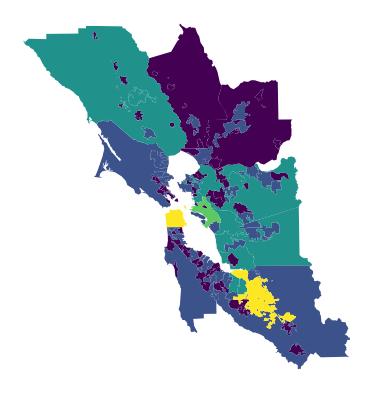

In [18]:
ax=jurisdictions.plot(column='hh',scheme='NaturalBreaks')
ax.axis('off')

In [67]:
# group cities into different size buckets

cities_top15 = dof_2019_hh.sort_values().tail(15).index.tolist()
cities_bottom15 = dof_2019_hh.sort_values().head(15).index.tolist()

# all other cities
cities_middle = list(set(dof_2019_hh.index)-set(cities_top15+cities_bottom15))

# combine then in a series
city_size_class = pd.Series({'Largest 15 (by 2019 households)': cities_top15, 'Smallest 15 (by 2019 households)': cities_bottom15,
                             'Middle Cities (by 2019 households)': cities_middle}).apply(pd.Series).stack().reset_index(name='juris').set_index('juris').level_0
city_size_class.name='city_group'

#### Parse RHNA 2014-2022 for later comparison

In [20]:
rhna_2014_2022 = pd.read_excel('data/final_rhna_methodology_model_RHNA5.xlsx',
                               'Final RHNA', skiprows=7, names=['juris', 'VLI', 'LI', 'MOD', 'MOD+', 'total'])

# extract county designation from top of each county group
rhna_2014_2022['county'] = rhna_2014_2022.loc[rhna_2014_2022['juris'].str.contains(
    'County$').fillna(False), 'juris']

# forward fill it
rhna_2014_2022.county = rhna_2014_2022.county.fillna(method='ffill')
rhna_2014_2022['county'] = rhna_2014_2022.county.str.replace(' County', '')


# remove those rows - they don't have data
rhna_2014_2022 = rhna_2014_2022.loc[~rhna_2014_2022['juris'].str.contains(
    'County$').fillna(False)]

# format uninc string
rhna_2014_2022.loc[rhna_2014_2022['juris'].str.contains('Uninc').fillna(False), 'juris'] =\
    'Unincorporated ' + rhna_2014_2022.loc[rhna_2014_2022['juris'].str.contains(
        'Uninc').fillna(False), 'county'].str.replace(' County', '')

rhna_2014_2022 = rhna_2014_2022[rhna_2014_2022.juris.notnull()]
rhna_2014_2022 = rhna_2014_2022[rhna_2014_2022.juris != 'REGION']

# store income distrib
rhna_2014_2022_inc = rhna_2014_2022.set_index(
    ['county', 'juris']).drop(['total'], axis=1).stack()
rhna_2014_2022_inc.index = rhna_2014_2022_inc.index.set_names(
    'income_group', level=2)

# store totals
rhna_2014_2022_cnty_juris = rhna_2014_2022.set_index(
    ['county', 'juris']).total.dropna()

rhna_2014_2022 = rhna_2014_2022.set_index('juris').total.dropna()

In [21]:
## RHNA 2014-2022, scaled to current RHND

rhna_2014_2022_inc_scaled = (
    rhna_2014_2022_inc*(RHND/rhna_2014_2022_cnty_juris.sum()))
rhna_2014_2022_inc_scaled.index = rhna_2014_2022_inc_scaled.index.set_names(
    'bayarea_ami', level=2)
rhna_2014_2022_inc_scaled = pd.concat([rhna_2014_2022_inc_scaled], keys=[(
    'RHNA 2015-2023 Scaled to 2023-2031 RHND', 'RHNA 2015-2023 Scaled to 2023-2031 RHND')], names=['approach', 'baseline'])

rhna_2014_2022_inc_scaled = rhna_2014_2022_inc_scaled.reset_index(name='value')
rhna_2014_2022_inc_scaled['equity_adjustment'] = "Unmodified Allocation"
rhna_2014_2022_inc_scaled = rhna_2014_2022_inc_scaled.set_index(
    ['approach', 'baseline', 'equity_adjustment', 'county', 'juris', 'bayarea_ami']).value
rhna_2014_2022_inc_scaled.sum(level=0)

approach
RHNA 2015-2023 Scaled to 2023-2031 RHND    441176.0
Name: value, dtype: float64

In [22]:
rhna_2014_2022_inc_raw = pd.concat([rhna_2014_2022_inc], keys=[(
    'RHNA 2015-2023', 'RHNA 2015-2023')], names=['approach', 'baseline'])
rhna_2014_2022_inc_raw.index = rhna_2014_2022_inc_raw.index.set_names(
    'bayarea_ami', level=4)

rhna_2014_2022_inc_raw = rhna_2014_2022_inc_raw.reset_index(name='value')
rhna_2014_2022_inc_raw['equity_adjustment'] = "Unmodified Allocation"
rhna_2014_2022_inc_raw = rhna_2014_2022_inc_raw.set_index(
    ['approach', 'baseline', 'equity_adjustment', 'county', 'juris', 'bayarea_ami']).value
rhna_2014_2022_inc_raw.sum(level=0)

approach
RHNA 2015-2023    187990.0
Name: value, dtype: float64

### Prep key allocation building blocks
* Baseline: Starting point for the allocation, like a jurisdiction's share of regional households
* Factors: Used to adjust up or down the baseline allocation. A jurisdiction with above-average scores on chosen factors will see an increase in baseline allocation; one with below-average scores will see a decrease, all other things equal.

#### Load baselines

In [23]:
baseline_variants = ['hh19',
                     'Blueprint', 'hh19_bp_1550_avg', 'bp_hh50_fnl']

all_baselines = ft.read_dataframe(
    'data/juris_baselines.feather').set_index('juris')
all_baselines=all_baselines[['hh19','jobs17','bp_hh50_dr','bp_hh50_fnl']]
all_baselines.head(2)

,hh19,jobs17,bp_hh50_dr,bp_hh50_fnl
juris,,,,
Alameda,0.011287,0.007327,0.009936,0.011001
Albany,0.002406,0.001111,0.002111,0.002064


#### Load factors

In [24]:
# load the raw factors - data describing each jurisdiction on a number of dimensions. Data is not yet normalized, but in native scale

combined_factors = ft.read_dataframe(
    'data/juris_factors_raw.feather').set_index('index')
combined_factors.head(2)

,Jobs-Housing Fit,Jobs-Housing Balance,Job Proximity - Transit,Job Proximity - Auto,Future Jobs,Transit Connectivity,Access to High Opportunity Areas,Natural Hazards,Divergence Index,Urbanized Area,Vehicle Miles Travelled (VMT),region
index,,,,,,,,,,,,
Alameda,2.161580,0.914639,2.570265,16.457525,0.007978,0.008630,0.658192,0.357121,0.046808,0.007296,26.137798,Bay Area
Albany,2.128745,0.569882,5.332756,16.531803,0.000896,0.006098,0.844947,0.798416,0.064831,0.001185,24.288622,Bay Area


Since the factors here are in their original scaling and some are ratios and some are percentages, we want to standardize them so they are on the same scale - with bounds from .5 to 1.5.  A jurisdiction in the top of the distribution on the raw factor will land it at or near 1.5. A jurisdiction at the bottom of the distribution for a factor will land it at or near .5.

This makes the interpretation relatively straightforward: A high scoring jurisdiction will see its baseline allocation **increased** by 1.5 for that factor. A low scoring one, conversely, will see its allocation **decreased** by .5.

In [25]:
combined_factors_SCALED=combined_factors.groupby('region').apply(rescale,new_range_low=.5,new_range_hi=1.5)


In [26]:
pd.concat([combined_factors,
           combined_factors_SCALED,
           ],
          keys=['0: orig', '1: standardized']).stack().unstack([1, 0]).sort_index(axis=1).loc[:, ['Orinda', 'Oakland', 'Santa Rosa', 'San Francisco']]

index                                  Orinda                    Oakland  \
                                      0: orig 1: standardized    0: orig   
Jobs-Housing Fit                      8.05859        0.643775    1.42037   
Jobs-Housing Balance                 0.550261        0.527577    1.25833   
Job Proximity - Transit             0.0685886         0.50471    7.03524   
Job Proximity - Auto                   18.135         1.06545    19.8096   
Future Jobs                       0.000861798        0.504998  0.0603333   
Transit Connectivity               0.00407894        0.517729   0.112553   
Access to High Opportunity Areas            1             1.5   0.242741   
Natural Hazards                      0.300151        0.694801   0.551137   
Divergence Index                     0.259603        0.915784   0.188968   
Urbanized Area                      0.0081092          0.5806  0.0383605   
Vehicle Miles Travelled (VMT)         33.8539         1.23513    23.6428   
region                               Bay Area             NaN   Bay Area   

index                                             Santa Rosa                  \
                                 1: standardized     0: orig 1: standardized   
Jobs-Housing Fit                        0.508765     2.16823        0.523976   
Jobs-Housing Balance                    0.607791     1.08448        0.588096   
Job Proximity - Transit                 0.983147      0.4157        0.528548   
Job Proximity - Auto                     1.11795     4.16542        0.627463   
Future Jobs                             0.855322   0.0171502        0.600947   
Transit Connectivity                    0.989206  0.00855085        0.537166   
Access to High Opportunity Areas        0.742741   0.0670747        0.567075   
Natural Hazards                         0.983569    0.881642         1.36383   
Divergence Index                        0.798504    0.172694        0.771483   
Urbanized Area                          0.897738   0.0266699        0.775181   
Vehicle Miles Travelled (VMT)           0.892173      18.137        0.707251   
region                                       NaN    Bay Area             NaN   

index                            San Francisco                  
                                       0: orig 1: standardized  
Jobs-Housing Fit                       2.68162        0.534417  
Jobs-Housing Balance                   1.96674        0.688042  
Job Proximity - Transit                14.5613             1.5  
Job Proximity - Auto                   31.9949             1.5  
Future Jobs                           0.169775             1.5  
Transit Connectivity                  0.230074             1.5  
Access to High Opportunity Areas      0.544208         1.04421  
Natural Hazards                       0.834096         1.30912  
Divergence Index                     0.0286886        0.532381  
Urbanized Area                        0.030861        0.819118  
Vehicle Miles Travelled (VMT)          14.5819        0.587848  
region                                Bay Area             NaN

In [27]:
# Check that the RANK (1 to 109) between original and scaled factor variable is consistent for a few cities
pd.options.display.float_format = '{:,.1f}'.format

pd.concat([combined_factors.drop(labels='region', axis=1),
           combined_factors_SCALED],
          keys=['orig', 'standardized']).stack().groupby(level=[0, 2]).rank(ascending=False).loc[:, ['Atherton', 'Brisbane', 'Livermore', 'Oakland', 'San Francisco']].unstack([1, 0]).sort_index(axis=1)

index                            Atherton              Brisbane               \
                                     orig standardized     orig standardized   
Jobs-Housing Fit                      1.5          1.5     24.0         24.0   
Jobs-Housing Balance                 59.0         59.0      4.0          4.0   
Job Proximity - Transit              18.0         18.0     66.0         66.0   
Job Proximity - Auto                 24.0         24.0     12.0         12.0   
Future Jobs                          96.0         96.0     58.0         58.0   
Transit Connectivity                 49.0         49.0     65.0         65.0   
Access to High Opportunity Areas     53.0         53.0     93.0         93.0   
Natural Hazards                       2.0          2.0    101.0        101.0   
Divergence Index                     40.0         40.0    109.0        109.0   
Urbanized Area                       70.0         70.0     87.0         87.0   
Vehicle Miles Travelled (VMT)        41.0         41.0     67.0         67.0   

index                            Livermore              Oakland               \
                                      orig standardized    orig standardized   
Jobs-Housing Fit                      45.0         45.0   103.0        103.0   
Jobs-Housing Balance                  26.0         26.0    44.0         44.0   
Job Proximity - Transit               69.0         69.0     4.0          4.0   
Job Proximity - Auto                  73.0         73.0    29.0         29.0   
Future Jobs                           24.0         24.0     3.0          3.0   
Transit Connectivity                  22.0         22.0     3.0          3.0   
Access to High Opportunity Areas      54.0         54.0    62.0         62.0   
Natural Hazards                       15.0         15.0    96.0         96.0   
Divergence Index                      73.0         73.0    56.0         56.0   
Urbanized Area                        16.0         16.0     4.0          4.0   
Vehicle Miles Travelled (VMT)         17.0         17.0    80.0         80.0   

index                            San Francisco               
                                          orig standardized  
Jobs-Housing Fit                          85.0         85.0  
Jobs-Housing Balance                      18.0         18.0  
Job Proximity - Transit                    1.0          1.0  
Job Proximity - Auto                       1.0          1.0  
Future Jobs                                1.0          1.0  
Transit Connectivity                       1.0          1.0  
Access to High Opportunity Areas          49.0         49.0  
Natural Hazards                           48.0         48.0  
Divergence Index                         106.0        106.0  
Urbanized Area                             5.0          5.0  
Vehicle Miles Travelled (VMT)            107.0        107.0

#### Define a dict with a name of each factor and an associated fraction of 1. 

The interpretation of these weights is: Allocate x percent of the allocation according to the jurisdiction-level distribution of the relevant factor. In other words, if the **Access to High Opportunity Areas** factor is assigned 20%, it means 20% of the RHND (in this case 20% of 441,776, or 88,235 units, will be distributed according to this factor.

In [28]:
factor_weights = {
    'Access to High Opportunity Areas': .1,
    'Divergence Index': .1,
    'Job Proximity - Auto': .1,
    'Job Proximity - Transit': .1,
    'Vehicle Miles Travelled (VMT)': .1,
    'Jobs-Housing Balance': .1,
    'Jobs-Housing Fit': .2,
    # 'Future Jobs':.1,
    'Transit Connectivity': .1,
    'Blueprint': .05,
    'Blueprint50': .00,
    'Urbanized Area': 0,
    'Blueprint_grrate': .00,
    'Blueprint_grrate_topcode': .00,
    'Natural Hazards': .05}

# check that they sum to 1
pd.Series(factor_weights).sum()

1.0

In [29]:
pd.options.display.float_format = '{:,.0f}'.format

## Income distribution `Approach C` bottom-up using factors for each category 
This is the approach the HMC preferred - that each income group be treated as its own allocation, with factors selected for each, and the allocation accordingly "run" four times, one for each income group. The resulting allocation is then simply the sum of the four income group allocations. 

### Enter factors and weigts in a dictionary for each variant. Dictionary is keyed on the four income groups

Each of them should sum to 100% - and the dicts will be passed to `run_allocation_inc` function

In [30]:
## HMC option 7A
factor_weights_2x_sep4 =\
    {
        'VLI': {'Access to High Opportunity Areas': 0.5,
                'Job Proximity - Auto': 0.25,
                'Job Proximity - Transit': 0.25
                },
        'LI': {'Access to High Opportunity Areas': 0.5,
               'Job Proximity - Auto': 0.25,
               'Job Proximity - Transit': 0.25
               },
        'MOD': {
            'Job Proximity - Auto': 0.5,
            'Access to High Opportunity Areas': 0.5
        },
        'MOD+': {
            'Job Proximity - Auto': 0.5,
            'Access to High Opportunity Areas': 0.5
        }}

In [31]:
## HMC option 8A
factor_weights_2x_eli_sep4 =\
    {
        'VLI': {'Access to High Opportunity Areas': .7,
                'Job Proximity - Auto': 0.15,
                'Job Proximity - Transit': 0.15
                },
        'LI': {'Access to High Opportunity Areas': .7,
               'Job Proximity - Auto': 0.15,
               'Job Proximity - Transit': 0.15
               },
        'MOD': {'Access to High Opportunity Areas': .4,
                'Job Proximity - Auto': 0.6
                },
        'MOD+': {'Access to High Opportunity Areas': .4,
                 'Job Proximity - Auto': 0.6
                 }}

In [32]:
## 8A / '2-F Bottom-Up HRA-Fit-Bal Sep 4' / - the winner
pd.options.display.float_format = '{:,.2f}'.format

pd.Series(factor_weights_2x_eli_sep4).apply(pd.Series).fillna(0).loc[income_cat_names]

,Access to High Opportunity Areas,Job Proximity - Auto,Job Proximity - Transit
VLI,0.70,0.15,0.15
LI,0.70,0.15,0.15
MOD,0.40,0.60,0.00
MOD+,0.40,0.60,0.00


### Prep weights and give meaningful names

Define more descriptive names for the variants

In [33]:
baseline_descriptive_names={#'BP_scaled_RHND': 'BP scaled to RHND',
    #'RHNA 2015-2023 Scaled to 2023-2031 RHND':'RHNA 2015-2023 Scaled to 2023-2031 RHND',
    #'RHNA 2015-2023':'RHNA 2015-2023',
    #'bp_hh15_50_dr':'Housing Growth (Blueprint Draft)',
    'bp_hh50_dr': '2050 Households (Blueprint Draft)',
    #'bp_hh15_50_fnl':'Housing Growth (Blueprint Final)',
    'bp_hh50_fnl': '2050 Households (Blueprint Final)',
    #'bp_hh50_soi': '2050 Households (Blueprint) SOI',
    'hh19': 'Households 2019',
    #'area_ua_os_clip':'Urbanized Land Area',
}

In [34]:
# Collect the approach dicts in a larger dict

approach_c_weights = {  # '2-F Bottom-Up':factor_weights_2x,
    # '3-F Bottom-Up':factor_weights_3x,
    # '3-F Bottom-Up 3+1':factor_weights_3x_3plus1,
    # '2-F Bottom-Up 3+1':factor_weights_2x_3plus1,
    # '2-F Bottom-Up HRA-Fit-Bal':factor_weights_2x_eli,
    # '2-F Bottom-Up HRA-Fit-Bal 3+1':factor_weights_2x_eli_3p1,
    '2-F Bottom-Up HRA-Fit-Auto Sep 4': factor_weights_2x_sep4,
    '2-F Bottom-Up HRA-Fit-Bal Sep 4': factor_weights_2x_eli_sep4,
}

In [35]:
# Add more friendly names - useful in the outputs

approach_map_nicename = {
    'Baseline Allocation': 'Baseline Allocation',
    'Blueprint Scaled to RHND': 'Blueprint Scaled to RHND',
    'Blueprint Factor Only': 'Blueprint Factor Only',
    'BP_scaled_RHND': 'BP Scaled to RHND',
    '2-F Bottom-Up HRA-Fit-Auto Aug 28': 'Option 5A: 50/50 High Opportunity Areas & Jobs',
    '2-F Bottom-Up HRA-Fit-Bal Aug 28': 'Option 6A: Modified High Opportunity Areas Emphasis',
    '2-F Bottom-Up HRA-Fit-Auto Sep 4': 'Option 7A: Balanced High Opportunity Areas & Job Proximity',
    '2-F Bottom-Up HRA-Fit-Bal Sep 4': 'Option 8A: High Opportunity Areas Emphasis & Job Proximity',
}

# grouping is useful in the R scripts for plotting purposes
approach_grouping = {
    '3-F Bottom-Up HRA-Transit-Auto Oct 15': 'Bottom Up',
    '2-F Bottom-Up HRA-Access': 'Bottom Up',
    '3-F Bottom-Up HRA-Access-Balance': 'Bottom Up',
    '3-F Bottom-Up HRA-Balance-Access': 'Bottom Up',
    'Baseline Allocation': 'Shift Approach',
    '3-F Bottom-Up Aug 28': 'Bottom Up',
    '2-F Bottom-Up HRA-Fit-Bal Aug 28': 'Bottom Up',
    '2-F Bottom-Up HRA-Fit-Auto Sep 4': 'Bottom Up',
    '2-F Bottom-Up HRA-Fit-Bal Sep 4': 'Bottom Up',
    '2-F Bottom-Up HRA-Fit-Bal Sep 4 Capped': 'Bottom Up',
    '2-F Bottom-Up HRA-Fit-Bal Sep 4 CDP': 'Bottom Up',
    '3-F Bottom-Up Aug 28': 'Bottom Up',
    '2-F Bottom-Up HRA-Fit-Auto Aug 28': 'Bottom Up',
    '2-F Bottom-Up HRA-Fit-Bal Aug 28': 'Bottom Up',
    u'2-F Bottom-Up HRA FIT': 'Bottom Up',
    u'3-F Bottom-Up 3+1': 'Bottom Up',
    u'2-F Bottom-Up 3+1': 'Bottom Up',
    u'3-F Bottom-Up': 'Bottom Up',
    'Housing / Jobs Crescent': 'Shift Approach', u'3-F Bottom-Up HRA boost': 'Bottom Up',
    u'2-F Bottom-Up': 'Bottom Up', u'3-F Bottom-Up HRA w BP Fact.': 'Bottom Up',
    u'Blueprint Scaled to RHND': 'Shift Approach',
    '2-F HRA PBA Only': 'Bottom Up', '2-F HRA PBA Only 3+1': 'Bottom Up',
    'Blueprint Factor Only': 'Shift Approach',
    'HRA PBA Factors': 'Shift Approach', 'BP_scaled_RHND': 'Shift Approach',
    '2-F Bottom-Up HRA-Fit-Bal 3+1': 'Bottom Up',
    '2-F Bottom-Up HRA-Fit-Bal': 'Bottom Up',
    'RHNA 2015-2023': 'RHNA 2015-2023',
    'RHNA 2015-2023 Scaled to 2023-2031 RHND': 'RHNA 2015-2023 Scaled to 2023-2031 RHND'}

In [36]:
# Check: Do they sum to 100% for each income group?

factor_weight_df = pd.Series(approach_c_weights).apply(pd.Series).stack().apply(pd.Series).stack(
).reset_index(name='value').rename(columns={'level_2': 'factor', 'level_1': 'Income Group'})
factor_weight_df['approach'] = factor_weight_df.level_0.map(
    approach_map_nicename)

# check that the weights sum to 1 for each income group for each approach
factor_weight_df.groupby(['approach', 'Income Group']).value.sum().unstack(0)

approach,Option 7A: Balanced High Opportunity Areas & Job Proximity,Option 8A: High Opportunity Areas Emphasis & Job Proximity
Income Group,,
LI,1.00,1.00
MOD,1.00,1.00
MOD+,1.00,1.00
VLI,1.00,1.00


## Run the RHNA allocation, with different baselines

In [37]:
pd.options.display.float_format = '{:,.0f}'.format
approach_c_weights

{'2-F Bottom-Up HRA-Fit-Auto Sep 4': {'VLI': {'Access to High Opportunity Areas': 0.5,
   'Job Proximity - Auto': 0.25,
   'Job Proximity - Transit': 0.25},
  'LI': {'Access to High Opportunity Areas': 0.5,
   'Job Proximity - Auto': 0.25,
   'Job Proximity - Transit': 0.25},
  'MOD': {'Job Proximity - Auto': 0.5,
   'Access to High Opportunity Areas': 0.5},
  'MOD+': {'Job Proximity - Auto': 0.5,
   'Access to High Opportunity Areas': 0.5}},
 '2-F Bottom-Up HRA-Fit-Bal Sep 4': {'VLI': {'Access to High Opportunity Areas': 0.7,
   'Job Proximity - Auto': 0.15,
   'Job Proximity - Transit': 0.15},
  'LI': {'Access to High Opportunity Areas': 0.7,
   'Job Proximity - Auto': 0.15,
   'Job Proximity - Transit': 0.15},
  'MOD': {'Access to High Opportunity Areas': 0.4,
   'Job Proximity - Auto': 0.6},
  'MOD+': {'Access to High Opportunity Areas': 0.4,
   'Job Proximity - Auto': 0.6}}}

In [38]:
# loop through dictionary with approaches (weights and factors)
# as well as a few different baselines - this is the actual allocation.
# then store results in dictionary

opt_c_methods_basevariation={}

for nme,dta in approach_c_weights.items():
    print(nme)
    for bsln in ['hh19','bp_hh50_dr','bp_hh50_fnl']:
        nme2=nme.replace('/','_').replace(' ','_').replace('__','_').replace('_-_','_').replace('__','_')
        RHNA_COMPARISON,RHNA_COMPARISON_combo=run_allocation_inc(
                                                        factor_weights_income=dta,
                                                        rhnd_income=RHND_INCOME,
                                                        new_range_hi=1.5,
                                                        new_range_low=.5,
                                                        baseline=bsln,
                                                        )

        opt_c_methods_basevariation[(nme,bsln)]=RHNA_COMPARISON
    
opt_c_methods_out_bslnvariant=pd.concat(opt_c_methods_basevariation,names=['variant','baseline'])
opt_c_methods_out_bslnvariant.index=opt_c_methods_out_bslnvariant.index.set_names('bayarea_ami',level=4)
opt_c_methods_out_bslnvariant.sum(axis=1).unstack('baseline').head()

2-F Bottom-Up HRA-Fit-Auto Sep 4
2-F Bottom-Up HRA-Fit-Bal Sep 4


baseline                                                      bp_hh50_dr  \
variant                          county  juris   bayarea_ami               
2-F Bottom-Up HRA-Fit-Auto Sep 4 Alameda Alameda VLI               1,252   
                                                 LI                  721   
                                                 MOD                 805   
                                                 MOD+              2,083   
                                         Albany  VLI                 306   

baseline                                                      bp_hh50_fnl  \
variant                          county  juris   bayarea_ami                
2-F Bottom-Up HRA-Fit-Auto Sep 4 Alameda Alameda VLI                1,378   
                                                 LI                   793   
                                                 MOD                  890   
                                                 MOD+               2,301   
                                         Albany  VLI                  297   

baseline                                                      hh19  
variant                          county  juris   bayarea_ami        
2-F Bottom-Up HRA-Fit-Auto Sep 4 Alameda Alameda VLI         1,433  
                                                 LI            825  
                                                 MOD           927  
                                                 MOD+        2,398  
                                         Albany  VLI           351

#### Manually define variants for subsetting from all the variants run (approaches by baseline)
The loop produced an allocation for each variant x baseline. We don't necessarily care for all the combinations - so we define a tuple with which to keep.

In [39]:
BASELINE = 'bp_hh50_fnl'
OPTION8A = '2-F Bottom-Up HRA-Fit-Bal Sep 4'

rhnd_income = RHND_INCOME
factor_weights_income = approach_c_weights[OPTION8A]


In [40]:
# Tuple with approach x baseline combinations to keep
variant_c_keepers=[
    ('2-F Bottom-Up HRA-Fit-Bal Sep 4','bp_hh50_fnl'),    
    ('2-F Bottom-Up HRA-Fit-Bal Sep 4','bp_hh50_dr'),    
        ]

In [41]:
# Filter approach C - get a Pandas Series, keyed on variant, baseline, county, juris, income

opt_c_approach_keep = opt_c_methods_out_bslnvariant.sum(axis=1).unstack(
    level=['variant', 'baseline']).loc(1)[pd.MultiIndex.from_tuples(variant_c_keepers)].stack(level=[0, 1])
opt_c_approach_keep.index = opt_c_approach_keep.index.set_names(
    ['county', 'juris', 'bayarea_ami', 'variant', 'baseline'])
opt_c_approach_keep = opt_c_approach_keep.reorder_levels(
    ['variant', 'baseline', 'county', 'juris', 'bayarea_ami'])

allocation_plain = opt_c_approach_keep.copy()

# set income group as factor variable for proper ordering, then add back to index
allocation_plain = allocation_plain.reset_index('bayarea_ami', name='value')
allocation_plain.bayarea_ami = allocation_plain.bayarea_ami.astype(
    pd.CategoricalDtype(categories=income_cat_names, ordered=True))
allocation_plain = allocation_plain.set_index(
    'bayarea_ami', append=True).value.sort_index()

allocation_plain.index = allocation_plain.index.set_names('approach', level=0)

allocation_plain = allocation_plain.sort_index()
allocation_plain.head()

approach                         baseline    county   juris    bayarea_ami
2-F Bottom-Up HRA-Fit-Bal Sep 4  bp_hh50_dr  Alameda  Alameda  VLI           1,318
                                                               LI              759
                                                               MOD             786
                                                               MOD+          2,033
                                                      Albany   VLI             324
Name: value, dtype: float64

### Check allocation against regional totals / RHND

Because of floating point precision used for factors and baseline, when rounding each city's allocation, a handful of units out of the 441k may be off relative to the RHND targets. This is a handful of units - we can't adjust this proportionately given the nature of the adjustment requiring a whole number. Instead, we select the city with the largest allocation, where it will all other things equal have the least impact. This city is San Francisco.

In [42]:
allocation_plain.loc[OPTION8A,'bp_hh50_fnl'].sum(level=['county','juris']).sort_values(ascending=False).head(3)

county         juris        
San Francisco  San Francisco   82,845
Santa Clara    San Jose        62,761
Alameda        Oakland         26,493
Name: value, dtype: float64

### Enforce regional controls

In [43]:
CORRECTION_CITY='San Francisco'

POST_CORRECTION=allocation_plain.groupby(level=['approach','baseline','bayarea_ami'],observed=True).sum()-pd.Series(RHND_INCOME,index=pd.Index(income_cat_names,name='bayarea_ami'))
tester=allocation_plain.copy()
allocation_plain.update(allocation_plain.loc[:,:,[CORRECTION_CITY]].add(POST_CORRECTION*-1))


allocation_plain.loc[OPTION8A,'bp_hh50_fnl'].reset_index().to_csv('/Users/aolsen/Box/Housing Needs Data Packets/sources/rhna_cycle6_opt8_bphh50.csv')

allocation_plain.loc[OPTION8A,['bp_hh50_dr','bp_hh50_fnl']].sum(level=['baseline','county','juris']).unstack([0]).rename(columns=baseline_descriptive_names).stack().floordiv(10).mul(10).unstack(2).to_excel('/Users/aolsen/Box/RHNA/Analyses/baseline/RHNA_8A_w_different_baselines_rounded.xlsx')

## did the adjustment work?
ADJUSTMENT_CHECK=allocation_plain.loc[OPTION8A,'bp_hh50_fnl'].unstack(2).sum()-pd.Series(RHND_INCOME)
ADJUSTMENT_CHECK.index=ADJUSTMENT_CHECK.index.set_names('bayarea_ami')
ADJUSTMENT_CHECK

bayarea_ami
VLI    0
LI     0
MOD    0
MOD+   0
dtype: float64

#### Adjustment effect
A reduction of four units for SF, with 3 fewer VLI, 6 fewer LI, 7 additional MOD, and 2 fewer MOD+. As shown below, this adjustment has very minor effects for the City of San Francisco's RHNA.

In [44]:
adj_diff = (allocation_plain.loc[[OPTION8A], [
            'bp_hh50_fnl']]-opt_c_approach_keep.loc[[OPTION8A], ['bp_hh50_fnl']])
print(adj_diff[adj_diff != 0])

print('Net effect: ', adj_diff[adj_diff != 0].sum())

approach                         baseline     county         juris          bayarea_ami
2-F Bottom-Up HRA-Fit-Bal Sep 4  bp_hh50_fnl  San Francisco  San Francisco  VLI           -3
                                                                            LI            -6
                                                                            MOD            7
                                                                            MOD+          -2
dtype: float64
Net effect:  -4.0


## Equity Adjustment

The Housing Methodology Committee came up with a list of 49 jurisdictions that are both more segregated and higher income than the average. The equity adjustment then looks at the two low income groups and sets a floor that is proportional to the city's share of regional households in 2020. If the city has 1.6 percent of the region's households, it will get 1.6 percent of the region's low income RHNA as well. See this Executive Board [appendix](http://mtc.legistar.com/gateway.aspx?M=F&ID=7bcacfc3-77ec-47a7-b224-68256428029a.pdf) for more information on the effects of this adjustment. Overall - just below 3,100 units (0.7%), out of 441,700, are shifted.

In [45]:
affh_advocate_list=pd.read_excel('data/AFFH Eval Criteria Proposal Data w uninc.xlsx','Data w uninc',skipfooter=1).set_index(['county','Jurisdiction'])

affh_advocate_list['advocate_class']=affh_advocate_list['Proposed Equity-Oriented Approach '].map({'NO':'Other jurisdictions','YES':'Jurisdictions with above-average divergence scores\nand % of households above 120% Area Median Income'})

affh_advocate_list.index=affh_advocate_list.index.set_names('juris',level=1)
affh_advocate_list=affh_advocate_list.advocate_class
affh_advocate_list=affh_advocate_list.replace('Jurisdictions with above-average divergence scores\nand % of households above 120% Area Median Income',
                          'Jurisdictions identified by HMC-proposed composite score for divergence index and % of households above 120% Area Median Income')
exclusionary_cities=affh_advocate_list[affh_advocate_list!='Other jurisdictions'].index.get_level_values(1)
exclusionary_cities

Index(['Menlo Park', 'Pleasanton', 'Sunnyvale', 'Belmont', 'Dublin',
       'Livermore', 'Millbrae', 'Pleasant Hill', 'Foster City', 'San Ramon',
       'Palo Alto', 'Hillsborough', 'Half Moon Bay', 'Hercules', 'San Carlos',
       'Los Altos', 'Los Altos Hills', 'Moraga', 'Los Gatos', 'Union City',
       'Fremont', 'Atherton', 'Orinda', 'Windsor', 'Saratoga', 'Daly City',
       'Lafayette', 'Piedmont', 'Monte Sereno', 'Clayton', 'Danville',
       'Gilroy', 'St. Helena', 'Healdsburg', 'Corte Madera', 'Woodside',
       'Portola Valley', 'Milpitas', 'Larkspur', 'Fairfax', 'Cupertino',
       'Tiburon', 'Mill Valley', 'Sausalito', 'San Anselmo', 'Ross',
       'Belvedere', 'Unincorporated Marin', 'Unincorporated Napa'],
      dtype='object', name='juris')

In [46]:
# load jurisdiction level classification variables - used for performance measures as well

measures_cat = pd.read_excel(
    'data/juris_measure_classification_binned_topversion_v2.xlsx').set_index(['county', 'juris'])

In [47]:
# add alt segregation city list from HMC members
measures_cat['Measure 5d.1 Comparison between the top 49 jurisdictions exhibiting above average racial and socioeconomic exclusion and the rest of the region'] =\
    measures_cat.index.get_level_values(1).map(
        affh_advocate_list.reset_index(0, drop=True))

measures_cat['Measure 5d.2 Comparison between the top 49 jurisdictions exhibiting above average racial and socioeconomic exclusion and the rest of the region'] =\
    measures_cat.index.get_level_values(1).map(
        affh_advocate_list.reset_index(0, drop=True))

In [48]:
# name of classification var for the exclusive cities
EXCLUSION_JURIS_VAR = u'Measure 5d.2 Comparison between the top 49 jurisdictions exhibiting above average racial and socioeconomic exclusion and the rest of the region'

allocation_perf_cat = allocation_plain.to_frame(
    name='units').join(measures_cat).reset_index()

### Define and run the adjustment

In [49]:
def equity_adjustment_v2(use_2020_hh=True):
    """Adjusts low income allocations (VLI+LI) if those allocations are less than proportional to 
    2020 household share of regional households."""
    
    #####################################################################
    # Aug 31 HMC equity measure - VLI+LI proportional to household share
    #####################################################################

    use_2020_hh = True

    # pick the households reference data for use in checking proportionality - default is 2020
    if use_2020_hh:
        juris_baseyear_households = dof_2020_hh
    else:
        juris_baseyear_households = dof_2019_hh

    # prepare a df with the basic RHNA allocation, but add the city classification into 49 vs the rest
    allocation_perf_cat = allocation_plain.to_frame(
        name='units').join(measures_cat).reset_index()

    # add extra grouping columns
    allocation_perf_cat['major_bins'] = allocation_perf_cat.bayarea_ami.map(
        major_groups)

    allocation_perf_cat.bayarea_ami = allocation_perf_cat.bayarea_ami.astype(
        str)

    
    # variable classifying cities into more vs less exclusionary cities per HMC measure
    exclusion_var = 'Measure 5d.2 Comparison between the top 49 jurisdictions exhibiting above average racial and socioeconomic exclusion and the rest of the region'
    exclusionary_category = 'Jurisdictions identified by HMC-proposed composite score for divergence index and % of households above 120% Area Median Income'

    # juris - level
    low_income_rhna_juris = (allocation_perf_cat[allocation_perf_cat.major_bins == 'Lower']
                             .groupby(['county', 'juris', 'approach', 'baseline', 'bayarea_ami'])
                             .units.sum().to_frame(name='units')
                             .join(measures_cat[exclusion_var])
                             .set_index(exclusion_var, append=True).units)

    # juris level lq - low income allocation share relative to overall household share
    # numerator is low income groups for a city as share of region
    low_income_rhna_numerator = (
        low_income_rhna_juris/low_income_rhna_juris.sum(level=['approach', 'baseline', 'bayarea_ami']))

    # denominator is juris share of regional households
    overall_hh_denominator = (juris_baseyear_households.to_frame(name='units').join(
        measures_cat[exclusion_var]).groupby(['juris', exclusion_var], observed=True).sum().units/juris_baseyear_households.sum())

    # then, the location quotient compares the percent VLI/sum(VLI) and LI/sum(LI) with households/sum(households)
    low_income_rhna_lq = (low_income_rhna_numerator /
                          overall_hh_denominator).reset_index()

    # the hypothetical VLI and LI allocation if proportional to jurisdiction's household share of region
    low_income_rhna_if_proportional = pd.concat([overall_hh_denominator * RHND_INCOME['VLI'],
                                                 overall_hh_denominator * RHND_INCOME['LI']], keys=['VLI', 'LI'], names=['bayarea_ami'])

    # deficit at jurisdiction level, each low income group
    approach_unit_deficit = ((low_income_rhna_juris
                             .subtract(low_income_rhna_if_proportional))
                             .sum(level=['juris', 'approach', 'baseline', 'bayarea_ami', exclusion_var])).reset_index()

    
    # round units to reallocate to integers
    approach_unit_deficit.units = approach_unit_deficit.units.map(np.ceil)
    
    # How many VLI/LI units are to be moved across the fence, from the remainder cities to the deficit ones?

    # jurisdiction level deficit
    juris_deficit = approach_unit_deficit[approach_unit_deficit.units < 0].set_index(
        ['juris', 'approach', 'baseline', exclusion_var, 'bayarea_ami']).units

    # sum to a total
    total_deficit = juris_deficit.groupby(
        level=['approach', 'baseline', exclusion_var, 'bayarea_ami']).sum()

    # 2a. Get the deficit from the group of 49 more exclusive jurisdictions
    total_deficit_from = total_deficit.loc[:, :, exclusionary_category]

    # flip the series sign: the deficit jurisdictions in the segregated group
    # needs that exact deficit added to reach proportionality

    juris_deficit *= -1

    # these deficits are to be taken from the non-49 ('control group') group of cities.
    # We take them in proportion to those cities' respective share of VLI+LI units

    #####################################################################################################
    ## Do the actual adjustment                                                                         #
    #####################################################################################################
    
    # start with low income allocations
    allocation_LI_for_adjustment = allocation_perf_cat.groupby(
        ['bayarea_ami', 'juris', 'approach', 'baseline', exclusion_var]).units.sum().loc[['LI', 'VLI']]

    # For sending cities, the less exclusionary group of 60 cities 
    # we sum the low income units by jurisdiction, exclusion group
    juris_vli_li_allocation_controlgroup = (allocation_LI_for_adjustment
                                            .loc[:, :, :, :, 'Other jurisdictions']
                                            .sum(level=['juris', 'approach', 'baseline', 'bayarea_ami']))

    # What is the share of the control group cities' VLI and LI?
    # we remove units in proportion to those shares
    juris_vli_li_allocation_controlgroup_share = juris_vli_li_allocation_controlgroup / \
        juris_vli_li_allocation_controlgroup.sum(
            level=['approach', 'baseline', 'bayarea_ami'])


    # Multiply the deficit with the share vli+li from the control group jurisdiction list
    adjustment_control_group = (
        total_deficit_from * juris_vli_li_allocation_controlgroup_share)

    # result - control group (60 less exclusionary cities)

    alloc_control = adjustment_control_group

    # result - case group (49 jurisdictions)

    alloc_case = juris_deficit.loc[:, :, :,
                                   exclusionary_category]

    # put the two series together - case and control, to get the full 109 jurisdictions
    # result is a delta: low income adjustment at city level - some are negative, some positive
    alloc_both = pd.concat(
        [alloc_case, alloc_control.reorder_levels(alloc_case.index.names)])

    # add the two low income adjustments (deltas) to the starting allocation

    allocation_equity_adj2 = allocation_plain.copy()

    allocation_equity_adj2 = allocation_equity_adj2.add(
        alloc_both, fill_value=0).reset_index(name='value')

    allocation_equity_adj2 = allocation_equity_adj2.set_index(
        ['county', 'juris', 'approach', 'baseline', 'bayarea_ami']).value

    return allocation_equity_adj2.round(0).astype(np.int64).reorder_levels(allocation_plain.index.names)

In [50]:
# call the equity adjustment function

allocation_equity_adj = equity_adjustment_v2(use_2020_hh=True)
allocation_equity_adj.head(4)

approach                         baseline    county   juris    bayarea_ami
2-F Bottom-Up HRA-Fit-Bal Sep 4  bp_hh50_dr  Alameda  Alameda  LI              742
                                                               MOD             786
                                                               MOD+           2033
                                                               VLI            1289
Name: value, dtype: int64

### Enforce regional controls - equity adjusted file

In [51]:
# collapse to regional totals - check against RHND income numbers
# set city with largest allocation as adjustment city
CORRECTION_CITY = 'San Francisco'

POST_CORRECTION = allocation_equity_adj.groupby(level=['approach', 'baseline', 'bayarea_ami'], observed=True).sum(
)-pd.Series(RHND_INCOME, index=pd.Index(income_cat_names, name='bayarea_ami'))
tester = allocation_equity_adj.copy()
allocation_equity_adj.update(allocation_equity_adj.loc[:, :, [
                             CORRECTION_CITY]].add(POST_CORRECTION*-1))

allocation_equity_adj.loc[OPTION8A, ['bp_hh50_dr', 'bp_hh50_fnl']].sum(level=['baseline', 'county', 'juris']).unstack([0]).rename(
    columns=baseline_descriptive_names).stack().floordiv(10).mul(10).unstack(2).to_excel('/Users/aolsen/Box/RHNA/Analyses/baseline/RHNA_8A_w_different_baselines_rounded.xlsx')

# did the adjustment work?
ADJUSTMENT_CHECK = allocation_equity_adj.loc[OPTION8A, 'bp_hh50_fnl'].unstack(
    2).sum()-pd.Series(RHND_INCOME)
ADJUSTMENT_CHECK.index = ADJUSTMENT_CHECK.index.set_names('bayarea_ami')
ADJUSTMENT_CHECK

bayarea_ami
LI      0
MOD     0
MOD+    0
VLI     0
dtype: int64

In [52]:
# See effect of adjustment
adj_diff_equity = (allocation_equity_adj.loc[[OPTION8A], [
                   'bp_hh50_fnl']]-tester.loc[[OPTION8A], ['bp_hh50_fnl']])
print(adj_diff_equity[adj_diff_equity != 0])

print('Net effect: ', adj_diff_equity[adj_diff_equity != 0].sum())

approach                         baseline     county         juris          bayarea_ami
2-F Bottom-Up HRA-Fit-Bal Sep 4  bp_hh50_fnl  San Francisco  San Francisco  VLI           -1
Name: value, dtype: int64
Net effect:  -1


#### Combine allocation with and without equity adjustment in one frame
Combines draft and final blueprint baselines, with and without equity adjustment

In [53]:
pd.options.display.float_format = '{:,.0f}'.format
allocation_plain_and_adjusted = pd.concat([allocation_equity_adj,
                                           allocation_plain],
                                          keys=['Allocation With Equity Adjustment',
                                                'Unmodified Allocation'],
                                          names=['equity_adjustment'])  # .reset_index()
allocation_plain_and_adjusted.loc[:, OPTION8A].unstack([0, 1])

equity_adjustment                         Allocation With Equity Adjustment  \
baseline                                                         bp_hh50_dr   
county  juris                 bayarea_ami                                     
Alameda Alameda               LI                                        742   
                              MOD                                       786   
                              MOD+                                    2,033   
                              VLI                                     1,289   
        Albany                LI                                        183   
...                                                                     ...   
Sonoma  Unincorporated Sonoma VLI                                     1,393   
        Windsor               LI                                        221   
                              MOD                                       118   
                              MOD+                                      305   
                              VLI                                       385   

equity_adjustment                                     Unmodified Allocation  \
baseline                                  bp_hh50_fnl            bp_hh50_dr   
county  juris                 bayarea_ami                                     
Alameda Alameda               LI                  818                   759   
                              MOD                 868                   786   
                              MOD+              2,246                 2,033   
                              VLI               1,422                 1,318   
        Albany                LI                  178                   187   
...                                               ...                   ...   
Sonoma  Unincorporated Sonoma VLI               1,036                 1,424   
        Windsor               LI                  221                   106   
                              MOD                 108                   118   
                              MOD+                279                   305   
                              VLI                 385                   184   

equity_adjustment                                      
baseline                                  bp_hh50_fnl  
county  juris                 bayarea_ami              
Alameda Alameda               LI                  837  
                              MOD                 868  
                              MOD+              2,246  
                              VLI               1,455  
        Albany                LI                  182  
...                                               ...  
Sonoma  Unincorporated Sonoma VLI               1,060  
        Windsor               LI                   97  
                              MOD                 108  
                              MOD+                279  
                              VLI                 168  

[436 rows x 4 columns]

### Run a few summaries

<AxesSubplot:ylabel='county'>

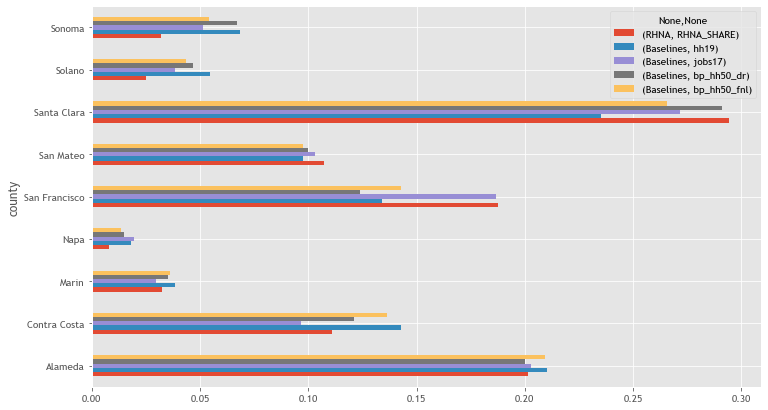

In [54]:
pd.concat([
    (allocation_plain.loc[OPTION8A, 'bp_hh50_fnl'].sum(level='county')/allocation_plain.loc[OPTION8A, 'bp_hh50_fnl'].sum(level='county').sum()),
all_baselines.join(jurisdictions.set_index('juris').county).set_index('county', append=True).sum(level='county')],keys=['RHNA','Baselines'],axis=1).rename(columns={'value':'RHNA_SHARE'}).plot(kind='barh')

Text(0.5, 1.0, 'RHNA Cycle 6')

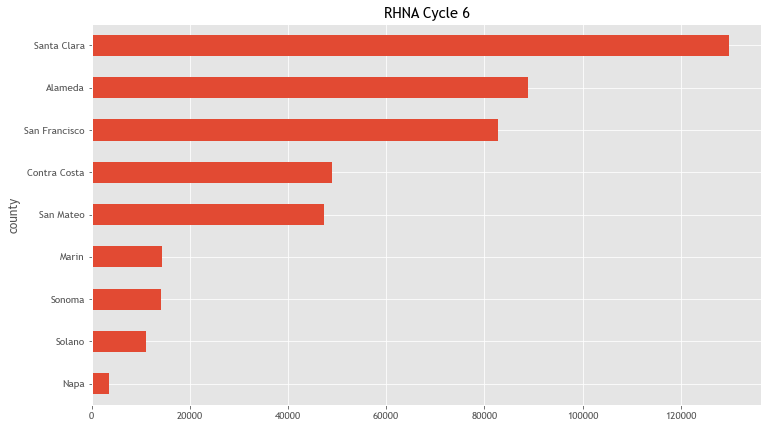

In [55]:
allocation_plain.loc[OPTION8A, 'bp_hh50_fnl'].sum(
    level=0).sort_values().plot(kind='barh')
title('RHNA Cycle 6')

#### Allocation location quotients (relative to 2019 hhs)

Text(0.5, 1.0, 'RHNA location quotient (allocation share relative to household share)\nRHNA Cycles 5 and 6')

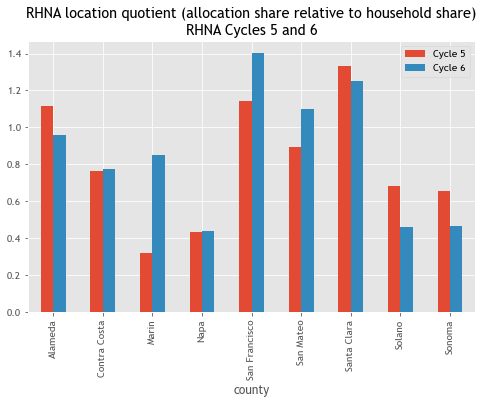

In [56]:
rhna_2023_2031_lq = allocation_plain.loc[OPTION8A, 'bp_hh50_fnl'].sum(level=['county'])/allocation_plain.loc[OPTION8A, 'bp_hh50_fnl'].sum(level=['county']).sum() /\
    (rhna_2014_2022_cnty_juris.to_frame().join(dof_2019_hh).sum(level=0)[
     'U Occupied']/rhna_2014_2022_cnty_juris.to_frame().join(dof_2019_hh).sum(level=0)['U Occupied'].sum())

# county level location quotient (lq)

rhna_2014_2022_lq = (rhna_2014_2022_cnty_juris.sum(level=0)/rhna_2014_2022_cnty_juris.sum(level=0).sum()) /\
    (rhna_2014_2022_cnty_juris.to_frame().join(dof_2019_hh).sum(level=0)[
     'U Occupied']/rhna_2014_2022_cnty_juris.to_frame().join(dof_2019_hh).sum(level=0)['U Occupied'].sum())
pd.concat([rhna_2014_2022_lq, rhna_2023_2031_lq], keys=[
          'Cycle 5', 'Cycle 6']).unstack(0).plot(kind='bar', figsize=[8, 5])
title('RHNA location quotient (allocation share relative to household share)\nRHNA Cycles 5 and 6')

#### RHNA in the big 3

In [57]:
allocation_plain.loc[OPTION8A, ['bp_hh50_fnl'], :, ['San Francisco', 'Oakland', 'San Jose']].sum(level=['approach', 'baseline'])\
    / allocation_plain.loc[OPTION8A, ['bp_hh50_fnl']].sum(level=['approach', 'baseline'])

allocation_plain.loc[OPTION8A, ['bp_hh50_fnl'], :, [
    'San Francisco', 'Oakland', 'San Jose']].sum(level=['approach', 'baseline'])

approach                         baseline   
2-F Bottom-Up HRA-Fit-Bal Sep 4  bp_hh50_fnl   172,095
Name: value, dtype: float64

In [58]:
pd.options.display.float_format = '{:,.2f}'.format
# how much of the RHND goes to the top 25 cities in terms of their allocations?

allocation_plain.loc[OPTION8A, ['bp_hh50_fnl']].sum(level=['approach', 'baseline', 'juris']).sort_values(ascending=False).head(25).sum(level=['approach', 'baseline'])\
    / allocation_plain.loc[OPTION8A, ['bp_hh50_fnl']].sum(level=['approach', 'baseline'])

approach                         baseline   
2-F Bottom-Up HRA-Fit-Bal Sep 4  bp_hh50_fnl   0.73
Name: value, dtype: float64

#### Allocation by city size class

In [83]:
# growth by size class
allocation_plain.loc[OPTION8A, 'bp_hh50_fnl'].to_frame().join(city_size_class).set_index('city_group', append=True).value.sum(level=[['city_group']])

city_group
Largest 15 (by 2019 households)      258,683.00
Middle Cities (by 2019 households)   177,754.00
Smallest 15 (by 2019 households)       4,739.00
Name: value, dtype: float64

#### Write out allocation to spreadsheet

In [59]:
adopted_out = allocation_plain_and_adjusted.loc['Allocation With Equity Adjustment',
                                                OPTION8A, 'bp_hh50_fnl'].reset_index(name='value')
adopted_out['Income Group'] = adopted_out.bayarea_ami.map(income_name_map).astype(pd.CategoricalDtype(income_name_map.values()))

writer = pd.ExcelWriter('output/rhna_allocation.xlsx',engine='xlsxwriter')

# Get the xlsxwriter workbook and worksheet objects.
workbook = writer.book

# Add a bold format to use to highlight cells.
cell_format_hdr = workbook.add_format({'bold': True, 'font_color': 'black','font_size':16})
cell_format = workbook.add_format({'bold': False, 'font_color': 'black','font_size':12})

readmeworksheet=workbook.add_worksheet(name='README')

readmeworksheet.write(0, 0, 'Proposed RHNA Allocation', cell_format_hdr)
readmeworksheet.write(2, 0, 'Weights:', cell_format)
readmeworksheet.write(2, 1, 'See sheet weights', cell_format)
readmeworksheet.write(4, 0, 'Baseline Used:', cell_format)
readmeworksheet.write(4, 1, 'Blueprint 2050 Households', cell_format)
pd.Series(factor_weights_income).apply(pd.Series).T.to_excel(writer,'weights')

adopted_out.groupby(['county', 'juris','Income Group'],observed=True).value.sum().unstack(2).to_excel(writer,'proposed_rhna_allocation')
writer.close()

#### Map it

In [60]:
# first, load a shapefile with a hexgrid for the region

hexgridv2 = gpd.read_file(
    'data/hexgrid_y13620.shp')
hexgridv2['jurisname_abbrev'] = hexgridv2.jurisdicti.map(jurisdictions.set_index('juris').jurisdicti.map(
    rem_vowel).str.replace('Unncrprtd', 'Unc').map(lambda x: '\n'.join(wrap(x, width=8))))
hexgridv2['county'] = hexgridv2.jurisdicti.map(
    jurisdictions.set_index('juris').county)
hexgridv2['city'] = hexgridv2.jurisdicti
hexgridv2 = hexgridv2[hexgridv2.juris != 'None']

hexgridv2_background = gpd.GeoSeries(
    hexgridv2.geometry.buffer(5000).unary_union.convex_hull)
hexgridv2_background_sq = gpd.GeoSeries(
    hexgridv2.geometry.buffer(5000).unary_union.envelope)

hexgridv2['coords'] = hexgridv2['geometry'].apply(
    lambda x: x.centroid.coords[:])
hexgridv2['coords'] = [coords[0] for coords in hexgridv2['coords']]

In [61]:
# prep a geodataframe with the adopted allocation and the hexgrid geometry

adopted_geo = allocation_plain_and_adjusted.loc[:, OPTION8A, 'bp_hh50_fnl'].sum(
    level=['equity_adjustment', 'county', 'juris']).unstack('equity_adjustment').reset_index()

adopted_geo['geometry'] = adopted_geo.juris.map(
    hexgridv2.set_index('jurisdicti').geometry)
adopted_geo = gpd.GeoDataFrame(adopted_geo, crs='EPSG:26910')
adopted_geo['coords'] = adopted_geo['geometry'].apply(
    lambda x: x.representative_point().coords[:])
adopted_geo['coords'] = [coords[0] for coords in adopted_geo['coords']]

adopted_geo['jurisname_abbrev'] = adopted_geo.juris.map(jurisdictions.set_index('juris').jurisdicti.map(
    rem_vowel).str.replace('Unncrprtd', 'Unc').map(lambda x: '\n'.join(wrap(x, width=8))))
# adopted_geo=adopted_geo.set_index(['county','juris'])
adopted_geo.head(3)

equity_adjustment,county,juris,Allocation With Equity Adjustment,Unmodified Allocation,geometry,coords,jurisname_abbrev
0,Alameda,Alameda,"5,354.00","5,406.00","POLYGON ((543945.437 4196665.881, 547877.194 4...","(551808.9510547959, 4200070.882799089)",Almd
1,Alameda,Albany,"1,114.00","1,125.00","POLYGON ((532150.165 4217095.891, 536081.922 4...","(540013.6795557053, 4213690.889149418)",Albny
2,Alameda,Berkeley,"8,934.00","9,025.00","POLYGON ((555740.708 4203475.884, 559672.465 4...","(563604.2225538867, 4200070.882799089)",Brkly


In [62]:
# define a mapping function

#cmap=cm.viridis
cmap=cm.RdBu_r

def map_juris_four_one_cb1(
        this_df,
        map_columns=['draft_rhna_alloc_bsln_grrate'],
        map_titles=['draft_rhna_alloc_bsln_grrate'],
        bounds=np.arange(0, .5, .05),
        labelmultiplier=100,
        labelformat='{juris}\n{num:.0f}%',
        cbarformat=percent_format,
        cmap=cm.coolwarm, cmap2=cm.RdYlBu,
        use_discrete=True,
        file_slug='',
        map_title='',
        figsize=[11, 11],
        ncols=2,
        nrows=2,
        add_colorbar=False,
        skip_cell=None,
        cbar_title='Jurisdiction Growth Rate',
        use_hex=False, labels=False,
        plot_hex_background=False,
        bgcol='lightgrey',
        wspace=-.3, hspace=.2,
        annot='ABAG HMC Meeting #10 | Item 7a 2 Appendix 1 | September 4, 2020',
        xy=(0., .5),
        subttl='',
        xy2=(0, 0),
        xy3=(.2, 0),
        wrap_width=60,
        facet_title_wrap=55,
        annot_desc='',
        annot_desc_wrap=60,
        save_images=False):

    vmax = this_df[map_columns].stack().max()
    vmin = this_df[map_columns].stack().min()
    vmean = this_df[map_columns].stack().mean()

    if use_discrete:
        # discrete colorbar
        #bounds = np.linspace(vmin,vmax,8)

        norm = mcolors.BoundaryNorm(boundaries=bounds, ncolors=256, clip=True)
        norm_neg = mcolors.BoundaryNorm(
            boundaries=np.arange(-.2, .21, .05), ncolors=256, clip=True)

    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=figsize)
    if type(axs) == ndarray:
        axs = axs.ravel()

    for i, map_column in enumerate(map_columns):
        new_i = i
        # if i>=skip_cell:
        #    new_i=i+1
        #    print 'skipping cell'
        if type(axs) == ndarray:
            # print '\tmulti'
            this_ax = axs[new_i]
        else:
            this_ax = axs

        norm_cont = MidPointNormalize(
            vmin, vmax, midpoint=this_df[map_column].median())
        if plot_hex_background:
            hexgridv2_background_sq.plot(
                color=bgcol, edgecolor='black', linewidth=.4, ax=this_ax)
        this_df.plot(column=map_column, edgecolor='black', linewidth=1.31, cmap=cmap,
                     legend=False, norm=norm,
                     ax=this_ax)

        this_df['coords'] = this_df['geometry'].apply(
            lambda x: x.centroid.coords[:])
        this_df['coords'] = [coords[0] for coords in this_df['coords']]

        this_ax.axis('off')
        this_ax.set_aspect('equal', 'box')
        this_ax.axes.get_xaxis().set_ticks([])
        this_ax.axes.get_yaxis().set_ticks([])

        this_ax.set_title('\n'.join(
            wrap(map_titles[i], width=facet_title_wrap)), size=13, fontweight='bold', y=.955)

        surplus_panels = ncols*nrows-len(map_columns)
        if surplus_panels > 0:
            # loop through last panels
            redundant_axs = axs[-surplus_panels:]
            for redundant_ax in redundant_axs:

                # wipe the skip cell panel
                redundant_ax.axis('off')
                redundant_ax.set_aspect('equal', 'box')
                redundant_ax.axes.get_xaxis().set_ticks([])
                redundant_ax.axes.get_yaxis().set_ticks([])

        if labels:
            this_df['this_bin'] = pd.cut(this_df[map_column], bins=list(
                bounds), labels=False)  # .astype(str)
            this_df['this_bin'] = this_df['this_bin'].fillna(0)
            color_bins = this_df['this_bin'].unique().shape[0]

            if use_hex:
                for idx, row in this_df.iterrows():
                    # this_ax.annotate(text='{juris}'.format(juris=row.jurisname_abbrev,
                    this_ax.annotate(text=labelformat.format(juris=row.jurisname_abbrev,
                                                             num=labelmultiplier *
                                                             row[map_column]
                                                             ), verticalalignment='center',
                                     color='black' if row.this_bin <= 2 else 'white', xy=row['coords'],
                                     horizontalalignment='center', size=8.5,
                                     #path_effects=[PathEffects.withStroke(linewidth=1.7, foreground="black")]
                                     )
            else:
                for idx, row in this_df[this_df[map_column] > 0].iterrows():
                    this_ax.annotate(text='{:.1f}'.format(100*row[map_column]), color='black', xy=row['coords'],
                                     ha='center', size=9,
                                     #path_effects=[PathEffects.withStroke(linewidth=1.7, foreground="black")]
                                     )

    plt.suptitle(map_title, size=14, fontweight='bold', y=.980)

    plt.tight_layout(rect=[0, .1, 1, .93])
    plt.subplots_adjust(wspace=wspace, hspace=hspace)
    plt.annotate(text=annot, color='black', xy=xy,
                 xycoords='figure fraction')

    plt.annotate(text='\n'.join(wrap(subttl, width=wrap_width)), color='black', xy=xy2,
                 xycoords='figure fraction', fontsize=12,
                 horizontalalignment='center')  # , fontweight='bold')

    if add_colorbar:
        cax1 = fig.add_axes([0.15, 0.08, 0.7, 0.02])

        # plt.Normalize(vmin=vmin, vmax=vmax))
        sm1 = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        # hack job for color bar
        sm1._A = []
        cbar1 = fig.colorbar(sm1, cax=cax1, orientation='horizontal', extend='both' if bounds[0] > 0 else 'max',
                             extendfrac=.2, spacing='uniform',  # 'proportional',
                             format=ticker.FuncFormatter(cbarformat))
        cbar1.ax.tick_params(labelsize=11)
        cbar1.ax.set_title(cbar_title, size=11)

    plt.annotate(text='\n'.join(wrap(annot_desc, width=annot_desc_wrap)),
                 color='black', style='italic',
                 xy=xy3,
                 #xycoords='figure fraction',
                 fontsize=8.5,
                 ha='left',
                 va='bottom',
                 xycoords='figure fraction',
                 bbox=dict(facecolor='white', ec='black',
                           lw=.5,  # alpha=0.75,
                           boxstyle="round,pad=0.4"))

    if save_images:
        savefig('plots/map_approach_compare{slug}.png'.format(
            slug='_%s' % file_slug if file_slug != '' else ''), dpi=300)
        savefig('plots/map_approach_compare{slug}.svg'.format(
            slug='_%s' % file_slug if file_slug != '' else ''))
        savefig('plots/map_approach_compare{slug}.pdf'.format(
            slug='_%s' % file_slug if file_slug != '' else ''))

#### Call the mapping function 

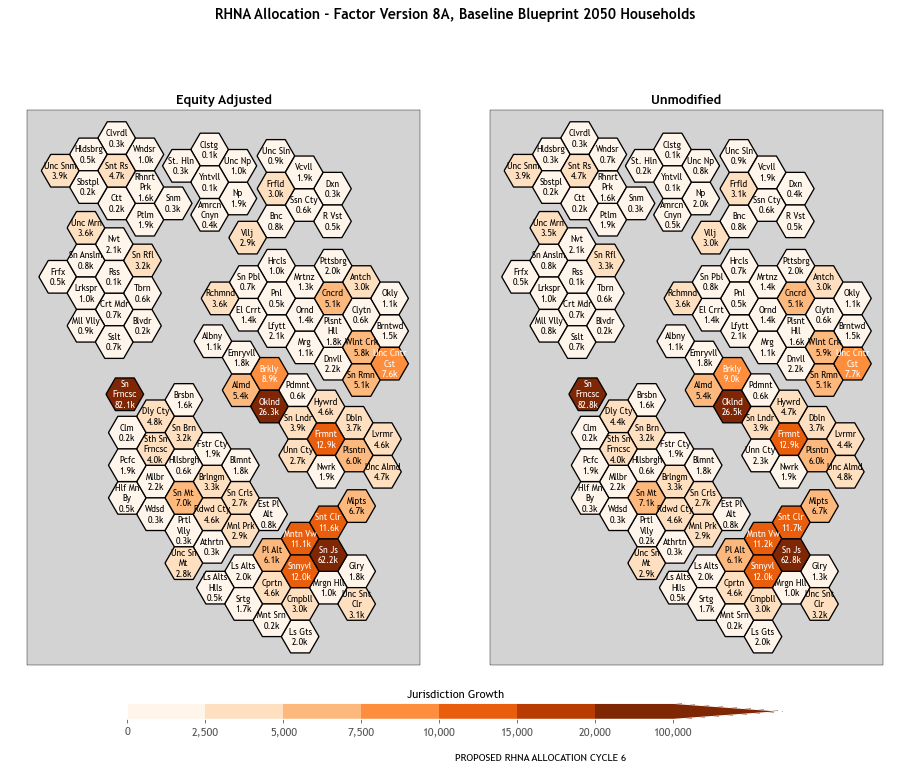

In [63]:
map_juris_four_one_cb1(adopted_geo,
                       map_columns=[
                           'Allocation With Equity Adjustment', 'Unmodified Allocation'],
                       map_titles=['Equity Adjusted', 'Unmodified'],
                       bounds=[0, 2500, 5000, 7500,
                               10000, 15000, 20000, 100000],
                       labelformat='%s' % '{juris}\n{num:.1f}k',
                       labelmultiplier=.001,
                       cbarformat=comma_fmt,
                       use_discrete=True,
                       ncols=2,
                       nrows=1,
                       cmap=cm.Oranges,
                       file_slug='allocation_8A',
                       map_title='RHNA Allocation - Factor Version 8A, Baseline Blueprint 2050 Households',    
                       cbar_title='Jurisdiction Growth',
                       skip_cell=None,
                       add_colorbar=True,
                       figsize=[13, 11],
                       use_hex=True,
                       # label_size=7.5,
                       wrap_width=40,
                       labels=True,
                       annot='PROPOSED RHNA ALLOCATION CYCLE 6',
                       hspace=.025, wspace=.025,
                       plot_hex_background=True,
                       facet_title_wrap=35,
                       xy=(.5, .02),
                       save_images=True)